In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from scipy.special import roots_legendre
from scipy.sparse.linalg import eigs

In [ ]:
# Constants
Np = 100
Nphi = 40
pi = np.pi
ONE = 1.0
ZERO = 0.0
Tel_deuteron = 1.0e-10
mass = 1.0
m = 0  # Orbital quantum number (for angular momentum)
n = 0  # Principal quantum number, must be >= msa
E_exact = -ONE / (n + 0.5)**2  # Exact energy for comparison
BE2_1 = E_exact * 0.95  # Slightly lower bound for energy estimate
BE2_2 = E_exact * 1.05  # Slightly upper bound for energy estimate

In [9]:
def hyperbolic(Np):
    """
    Generate momentum points and weights using a hyperbolic distribution.
    """
    X, dX = roots_legendre(Np)
    P = (1.0 + X) / (1.0 - X)
    dP = 2.0 / (1.0 - X)**2 * dX
    return P, dP

def linear(Nphi, a, b):
    """
    Generate linearly spaced angular points and weights.
    """
    X, dX = roots_legendre(Nphi)
    x = (b - a) / 2 * X + (b + a) / 2
    dx = (b - a) / 2 * dX
    return x, dx

In [10]:
def compute_V_2B(Np, Nphi, m, p, xp, phi, dphi):
    """
    Compute the potential matrix V_2B and integrate over the angular coordinate phi.
    """
    V_2B = np.zeros((Np, Np, Nphi))
    for ip in range(Np):
        for ipp in range(Np):
            for ixp in range(Nphi):
                q = np.sqrt(p[ip]**2 + p[ipp]**2 - 2 * p[ip] * p[ipp] * xp[ixp])
                V_2B[ip, ipp, ixp] = -1.0 / (q * pi)

    V_2B_2d = np.zeros((Np, Np))
    cos_terms = np.cos(m * phi)
    for ipp in range(Np):
        for ip in range(Np):
            V_2B_2d[ip, ipp] = np.sum(dphi * V_2B[ip, ipp, :] * cos_terms)

    return V_2B_2d

In [11]:
def eigenvalue(Mmatrix):
    """
    This function calculates a few eigenvalues and eigenvectors of the matrix Mmatrix.

    Args:
        Mmatrix (numpy.ndarray): A square matrix from which to find eigenvalues and eigenvectors.

    Returns:
        WF (numpy.ndarray): The eigenvectors corresponding to the largest eigenvalue.
        Lambda (float): The largest eigenvalue.
    """
    # Determine the size of the matrix
    dim_Mmatrix = Mmatrix.shape[0]

    # Specify the number of eigenvalues and eigenvectors to find
    # NEV: number of eigenvalues,
    # NCV: number of Arnoldi vectors, must be greater than NEV
    NEV = 10
    NCV = 2 * NEV # A larger NCV can accelerate convergence
    # Use 'LM' (Largest Magnitude) or 'LR' (Largest Real part) as needed
    WHICH = 'LR'
    # Find NEV eigenvalues with the largest magnitude
    eigenvalues, eigenvectors = eigs(Mmatrix, k=NEV, which=WHICH, ncv=NCV)
    # Target eigenvalue near 1
    target_eigenvalue = 1.0
    idx_min = np.argmin(np.abs(eigenvalues - target_eigenvalue))
    Lambda = eigenvalues[idx_min]
    WF = np.abs(eigenvectors[:, idx_min])

    return WF, Lambda

In [12]:
def LS_2D(Np, pp, dp, V_2B):
    """
    Solve the Lippmann-Schwinger equation in 2D for the given potential matrix.

    Args:
        Np (int): Number of momentum grid points.
        pp (np.ndarray): Array of momentum values, shape (Np,).
        dp (np.ndarray): Differential weights associated with pp, shape (Np,).
        V_2B (np.ndarray): Non-relativistic potential matrix, shape (Np, Np).

    Returns:
        float: The energy eigenvalue closest to the expected bound state energy.
        np.ndarray: Normalized eigenvector corresponding to the computed eigenvalue.
    """
    Ne = 20
    BE_ary = np.zeros(Ne)
    Lam_ary = np.zeros(Ne)
    BE_ary[0] = BE2_1
    BE_ary[1] = BE2_2

    for ie in range(Ne):
        if ie > 1:
            BE_ary[ie] = BE_ary[ie-1] + (1 - Lam_ary[ie-1]) / (Lam_ary[ie-2] - Lam_ary[ie-1]) * (BE_ary[ie-2] - BE_ary[ie-1])
        BE2 = BE_ary[ie]
        Mmatrix = np.zeros((Np, Np))
        for ip in range(Np):
            for ipp in range(Np):
                denom = (BE2 - pp[ip]**2 / mass)
                if denom != 0:
                    Mmatrix[ip, ipp] = dp[ipp] * pp[ipp] * V_2B[ip, ipp] / denom

        WF, Lambda = eigenvalue(Mmatrix)
        WF /= np.sqrt(np.sum(WF**2 * dp * pp))

        Lam_ary[ie] = Lambda
        print(f"Iteration {ie} | BE2 = {BE2}, Lambda = {Lambda}")

        if np.abs(Lambda - 1.0) < Tel_deuteron:
            break

    return BE2, WF

C:\Users\Kayvon\AppData\Local\Temp\ipykernel_2908\174736244.py:35: ComplexWarning: Casting complex values to real discards the imaginary part
  Lam_ary[ie] = Lambda


Iteration 0 | BE2 = -3.8, Lambda = (1.0398196846652865+0j)
Iteration 1 | BE2 = -4.2, Lambda = (0.9892556967381615+0j)
Iteration 2 | BE2 = -4.115004304824029, Lambda = (0.9993796419376192+0j)
Iteration 3 | BE2 = -4.1097960817715276, Lambda = (1.0000101998578528+0j)
Iteration 4 | BE2 = -4.109880329598883, Lambda = (0.9999999871522594+0j)
Iteration 5 | BE2 = -4.109880223613821, Lambda = (1.0000000029116178+0j)
Iteration 6 | BE2 = -4.109880243195075, Lambda = (1.0000000005500909+0j)
Iteration 7 | BE2 = -4.109880247756306, Lambda = (0.9999999999994016+0j)
Final BE2: -4.109880247756306
Exact BE2: -4.0
Rel % Difference: 2.747006193907642


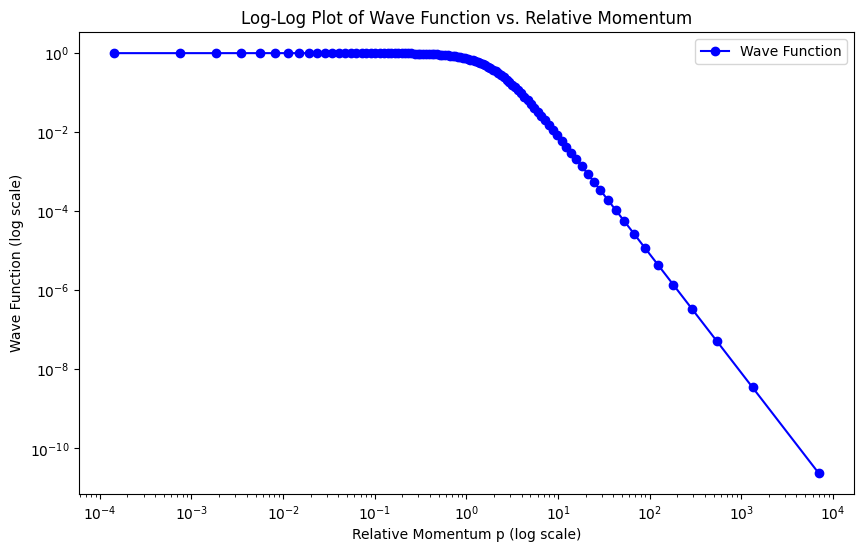

In [13]:
def main():
    """
    Main function to orchestrate the computation and visualization.
    """
    p, dp = hyperbolic(Np)
    phi, dphi = linear(Nphi, 0, 2.0 * pi)
    xp = np.cos(phi)
    V_2B_2d = compute_V_2B(Np, Nphi, m, p, xp, phi, dphi)
    BE2, WF = LS_2D(Np, p, dp, V_2B_2d)
    rel_error = np.abs((BE2 - E_exact) / E_exact) * 100

    print(f'Final BE2: {BE2}')
    print(f'Exact BE2: {E_exact}')
    print(f'Rel % Difference: {rel_error}')

    plt.figure(figsize=(10, 6))
    plt.loglog(p, WF, 'bo-', label='Wave Function')
    plt.xlabel('Relative Momentum p (log scale)')
    plt.ylabel('Wave Function (log scale)')
    plt.title('Log-Log Plot of Wave Function vs. Relative Momentum')
    # plt.grid(True, which="both", ls="--")
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from scipy.special import roots_legendre
from scipy.sparse.linalg import eigs

In [15]:
# Constants
Np = 200
Nphi = 40
pi = np.pi
ONE = 1.0
ZERO = 0.0
Tel_deuteron = 1.0e-10
mass = 1.0
m = 0  # Orbital quantum number (for angular momentum)

In [16]:
def hyperbolic(Np):
    """
    Generate hyperbolic distribution points and their weights using Legendre roots.
    Returns:
        (P, dP): Tuple of numpy arrays of shape (Np,)
                 P is the transformed momentum points
                 dP is the corresponding weights
    """
    X, dX = roots_legendre(Np)
    P = (1.0 + X) / (1.0 - X)
    dP = 2.0 / (1.0 - X)**2 * dX
    return P, dP

def linear(Nphi, a, b):
    """
    Generate linear distribution points and their weights for variables over an interval [a, b].
    Args:
        Nphi (int): Number of points in phi.
        a (float): Start of the interval.
        b (float): End of the interval.

    Returns:
        (x, dx): Tuple of numpy arrays of shape (Nphi,)
                 x is the linearly mapped points from [-1, 1] to [a, b]
                 dx is the corresponding weights
    """
    X, dX = roots_legendre(Nphi)
    x = (b - a) / 2 * X + (b + a) / 2
    dx = (b - a) / 2 * dX
    return x, dx


In [17]:
def eigenvalue(Mmatrix):
    """
    This function calculates a few eigenvalues and eigenvectors of the matrix Mmatrix.

    Args:
        Mmatrix (numpy.ndarray): A square matrix from which to find eigenvalues and eigenvectors.

    Returns:
        WF (numpy.ndarray): The eigenvectors corresponding to the largest eigenvalue.
        Lambda (float): The largest eigenvalue.
    """
    # Determine the size of the matrix
    dim_Mmatrix = Mmatrix.shape[0]

    # Specify the number of eigenvalues and eigenvectors to find
    # NEV: number of eigenvalues,
    # NCV: number of Arnoldi vectors, must be greater than NEV
    NEV = 10
    NCV = 2 * NEV # A larger NCV can accelerate convergence
    # Use 'LM' (Largest Magnitude) or 'LR' (Largest Real part) as needed
    WHICH = 'LR'
    # Find NEV eigenvalues with the largest magnitude
    eigenvalues, eigenvectors = eigs(Mmatrix, k=NEV, which=WHICH, ncv=NCV)
    # Target eigenvalue near 1
    target_eigenvalue = 1.0
    idx_min = np.argmin(np.abs(eigenvalues - target_eigenvalue))
    Lambda = eigenvalues[idx_min]
    WF = np.abs(eigenvectors[:, idx_min])

    return WF, Lambda

In [18]:
def compute_V_2B(Np, Nphi, m, p, xp, phi, dphi):
    """
    Computes the 3D array V_2B (for potential calculations) and integrates it
    over phi to form a 2D array V_2B_2d.

    Args:
        Np (int): Number of p points
        Nphi (int): Number of phi points
        m: state quantum number
        p (np.ndarray): 1D array of momentum values of length Np
        xp (np.ndarray): 1D array of cos(phi) values of length Nphi
        dphi (np.ndarray): 1D array of differential phi weights of length Nphi

    Returns:
        V_2B_2d (np.ndarray): 2D array of shape (Np, Np), the integrated potential over phi
    """
    # Initialize the V_2B 3D array
    V_2B = np.zeros((Np, Np, Nphi))

    # Populate the V_2B array
    for ip in range(Np):
        for ipp in range(Np):
            for ixp in range(Nphi):
                q = np.sqrt(p[ip]**2 + p[ipp]**2
                            - 2.0 * p[ip] * p[ipp] * xp[ixp])
                # Potential V2B_q = -1 / (q*pi)
                V_2B[ip, ipp, ixp] = -1.0 / (q * pi)

    # Integrate V_2B over phi to produce V_2B_2d
    V_2B_2d = np.zeros((Np, Np))
    cos_terms = np.cos(m * phi)  # This computes the cosine term for all phi values

    for ipp in range(Np):
        for ip in range(Np):
          # phi integration
           V_2B_2d[ip, ipp] = np.sum(dphi * V_2B[ip, ipp, :] * cos_terms)

    return V_2B_2d

In [19]:
def LS_2D(Np, pp, dp, V_NR, BE2_1, BE2_2):
    """
    Demonstration routine for computing eigenvalues using the 2D LS approach.

    Args:
        Np (int): Number of momentum points
        pp (np.ndarray): Momentum array of shape (Np,)
        dp (np.ndarray): Weights array associated with pp
        V_NR (np.ndarray): 2D potential array V_NR of shape (Np, Np)

    Returns:
        (BE2, WF): Tuple of (float, np.ndarray)
                   BE2 is the last computed energy
                   WF is the corresponding wave function array of shape (Np,)
    """
    Ne = 20
    BE_ary = np.zeros(Ne)
    Lam_ary = np.zeros(Ne)
    BE_ary[0] = BE2_1
    BE_ary[1] = BE2_2

    for ie in range(Ne):
        # Extrapolation-like step if needed:
        if ie > 1:
            BE_ary[ie] = (BE_ary[ie-1]
                          + (1 - Lam_ary[ie-1])/(Lam_ary[ie-2] - Lam_ary[ie-1])
                          * (BE_ary[ie-2] - BE_ary[ie-1]))
        BE2 = BE_ary[ie]

        # Build the matrix
        Mmatrix = np.zeros((Np, Np))
        for ip in range(Np):
            for ipp in range(Np):
                denom = (BE2 - pp[ip]**2 / mass)
                if denom != 0:
                    Mmatrix[ip, ipp] = (dp[ipp] * pp[ipp] * V_NR[ip, ipp] / denom)

        WF, Lambda = eigenvalue(Mmatrix)
        # Normalize WF
        WF /= np.sqrt(np.sum(WF**2 * dp * pp))

        Lam_ary[ie] = np.real(Lambda)
        print(f"Iteration {ie} | BE2 = {BE2}, Lambda = {Lambda}")

        if np.abs(Lambda - 1.0) < Tel_deuteron:
            break

    return BE2, WF


Iteration 0 | BE2 = -3.8, Lambda = (1.02979888620005+0j)
Iteration 1 | BE2 = -4.2, Lambda = (0.9796041845848711+0j)
Iteration 2 | BE2 = -4.0374663878152335, Lambda = (0.9990984219240998+0j)
Iteration 3 | BE2 = -4.029949461720989, Lambda = (1.0000284738982166+0j)
Iteration 4 | BE2 = -4.030179595298967, Lambda = (0.9999999266415279+0j)
Iteration 5 | BE2 = -4.030179003919983, Lambda = (0.9999999996828505+0j)
Iteration 6 | BE2 = -4.030179001352182, Lambda = (1.0000000003186256+0j)
Iteration 7 | BE2 = -4.030179002639064, Lambda = (1.0000000003145815+0j)
Iteration 8 | BE2 = -4.030179102742746, Lambda = (0.9999999877535981+0j)
Iteration 9 | BE2 = -4.030179005146094, Lambda = (0.9999999932462561+0j)
Iteration 10 | BE2 = -4.030178885141754, Lambda = (1.0000000107334435+0j)
Iteration 11 | BE2 = -4.030178958799099, Lambda = (1.0000000283427355+0j)
Iteration 12 | BE2 = -4.030178840245176, Lambda = (0.9999999899663318+0j)
Iteration 13 | BE2 = -4.030178871241586, Lambda = (1.0000000076610616+0j)
Ite

<Figure size 1000x600 with 0 Axes>

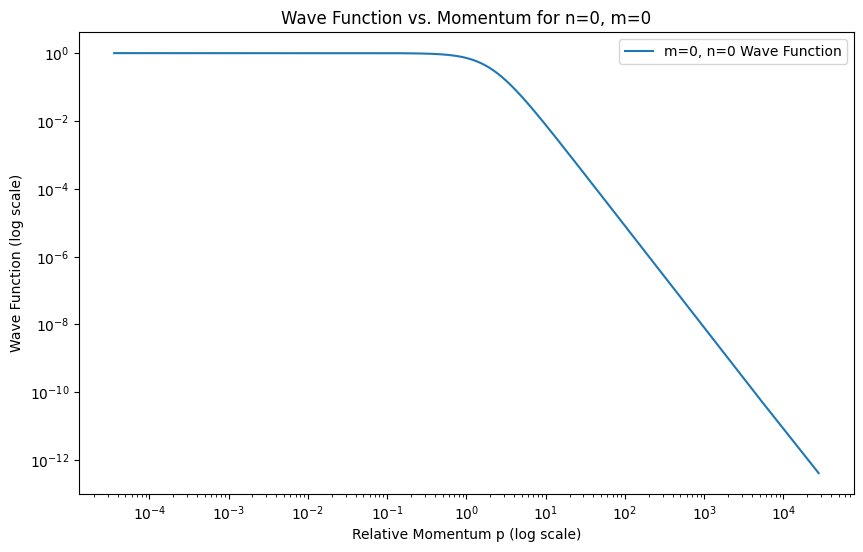

Iteration 0 | BE2 = -0.42222222222222217, Lambda = (1.0355705170407212+0j)
Iteration 1 | BE2 = -0.4666666666666667, Lambda = (0.9849182292384583+0j)
Iteration 2 | BE2 = -0.45343328764631685, Lambda = (0.999217783091906+0j)
Iteration 3 | BE2 = -0.4527093928362394, Lambda = (1.0000152810386753+0j)
Iteration 4 | BE2 = -0.45272326354855214, Lambda = (0.9999976777317223+0j)
Iteration 5 | BE2 = -0.45272143369264617, Lambda = (1.0000021288428282+0j)
Iteration 6 | BE2 = -0.4527223088619083, Lambda = (1.000001157230173+0j)
Iteration 7 | BE2 = -0.45272335122407925, Lambda = (1.0000000739575368+0j)
Iteration 8 | BE2 = -0.4527234223885636, Lambda = (0.999999930180919+0j)
Iteration 9 | BE2 = -0.45272338783051813, Lambda = (0.9999999403085938+0j)
Iteration 10 | BE2 = -0.45272318414918283, Lambda = (1.000000530092715+0j)
Iteration 11 | BE2 = -0.45272336721615286, Lambda = (1.000000059422792+0j)
Iteration 12 | BE2 = -0.4527233903286356, Lambda = (0.9999999500362813+0j)
Iteration 13 | BE2 = -0.45272337

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

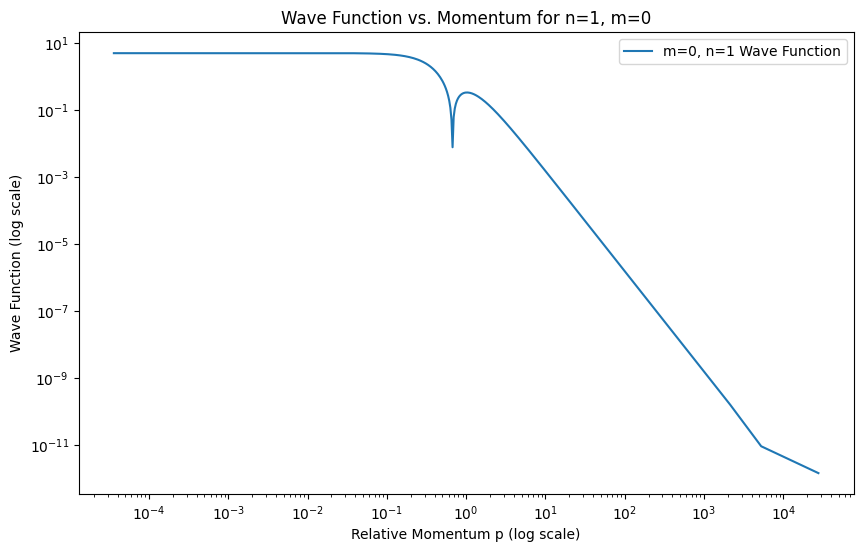

Iteration 0 | BE2 = -0.152, Lambda = (1.045451800663405+0j)
Iteration 1 | BE2 = -0.168, Lambda = (0.9939871678750123+0j)
Iteration 2 | BE2 = -0.16613065189068052, Lambda = (0.9996096481183847+0j)
Iteration 3 | BE2 = -0.1660008686775288, Lambda = (1.0000103305271497+0j)
Iteration 4 | BE2 = -0.16600421479150265, Lambda = (0.999994260622108+0j)
Iteration 5 | BE2 = -0.16600301972454268, Lambda = (0.9999990817535788+0j)
Iteration 6 | BE2 = -0.16600279210868824, Lambda = (0.9999955992297364+0j)
Iteration 7 | BE2 = -0.16600307974062675, Lambda = (1.0000032018832536+0j)
Iteration 8 | BE2 = -0.1660029586034626, Lambda = (0.9999987439500119+0j)
Iteration 9 | BE2 = -0.16600299273460034, Lambda = (0.9999978544280342+0j)
Iteration 10 | BE2 = -0.16600291040857112, Lambda = (1.0000017363614453+0j)
Iteration 11 | BE2 = -0.16600294723242356, Lambda = (0.999998760906012+0j)
Iteration 12 | BE2 = -0.16600293189755627, Lambda = (0.9999990962730685+0j)
Iteration 13 | BE2 = -0.1660028905740801, Lambda = (0.9

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

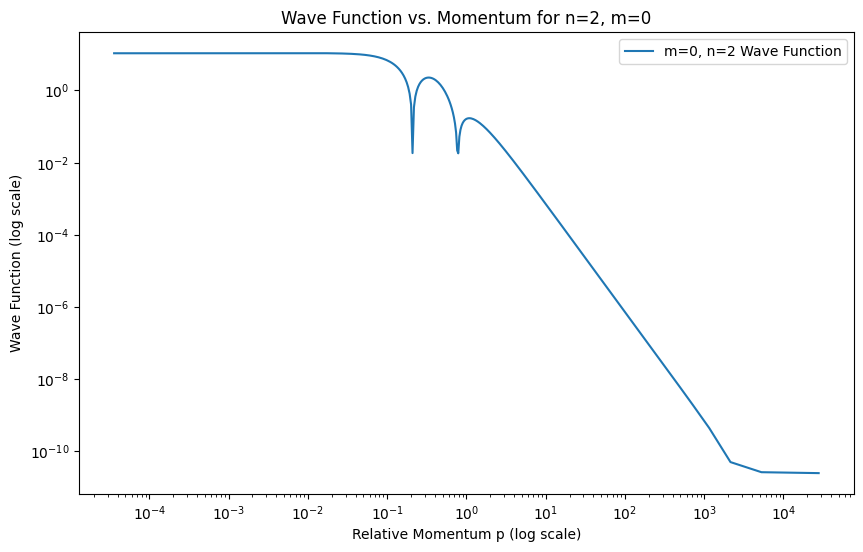

Iteration 0 | BE2 = -0.07755102040816325, Lambda = (1.0587563528003432+0j)
Iteration 1 | BE2 = -0.08571428571428572, Lambda = (1.0061936970872774+0j)
Iteration 2 | BE2 = -0.08667620043992684, Lambda = (1.0005052704283293+0j)
Iteration 3 | BE2 = -0.08676164182725252, Lambda = (0.999995071042361+0j)
Iteration 4 | BE2 = -0.08676081639117726, Lambda = (1.0000030936986202+0j)
Iteration 5 | BE2 = -0.08676113469603347, Lambda = (1.0000011934280528+0j)
Iteration 6 | BE2 = -0.08676133460122133, Lambda = (1.0000008648021503+0j)
Iteration 7 | BE2 = -0.08676186066576773, Lambda = (1.0000401764310183+0j)
Iteration 8 | BE2 = -0.08676132302851972, Lambda = (0.9999999804451661+0j)
Iteration 9 | BE2 = -0.08676132329007337, Lambda = (1.0000047478598661+0j)
Iteration 10 | BE2 = -0.08676132302959255, Lambda = (0.9999841693601083+0j)
Iteration 11 | BE2 = -0.08676132322997539, Lambda = (1.0000030894455725+0j)
Iteration 12 | BE2 = -0.08676132319725503, Lambda = (1.000002717487252+0j)
Iteration 13 | BE2 = -0.

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

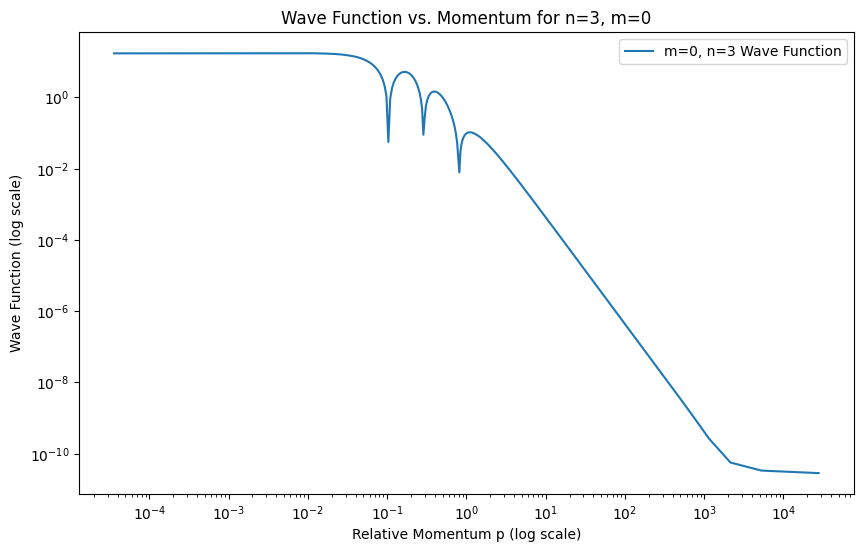

Iteration 0 | BE2 = -0.046913580246913576, Lambda = (1.0754051522534742+0j)
Iteration 1 | BE2 = -0.05185185185185185, Lambda = (1.021409725433112+0j)
Iteration 2 | BE2 = -0.05380992581110781, Lambda = (1.002154262944728+0j)
Iteration 3 | BE2 = -0.05402899124129452, Lambda = (1.0000540775594686+0j)
Iteration 4 | BE2 = -0.05403463194516361, Lambda = (0.9999954730604528+0j)
Iteration 5 | BE2 = -0.05403419622562248, Lambda = (1.0000055968830808+0j)
Iteration 6 | BE2 = -0.054034437110060826, Lambda = (1.000010197480293+0j)
Iteration 7 | BE2 = -0.05403390317626928, Lambda = (1.0000085285956553+0j)
Iteration 8 | BE2 = -0.05403117458418352, Lambda = (1.0000610248938586+0j)
Iteration 9 | BE2 = -0.054034346465785, Lambda = (1.000016222632777+0j)
Iteration 10 | BE2 = -0.05403549498528357, Lambda = (1.000007124149434+0j)
Iteration 11 | BE2 = -0.05403639428071856, Lambda = (0.999974973388107+0j)
Iteration 12 | BE2 = -0.054035694256305465, Lambda = (0.9999907508670361+0j)
Iteration 13 | BE2 = -0.054

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

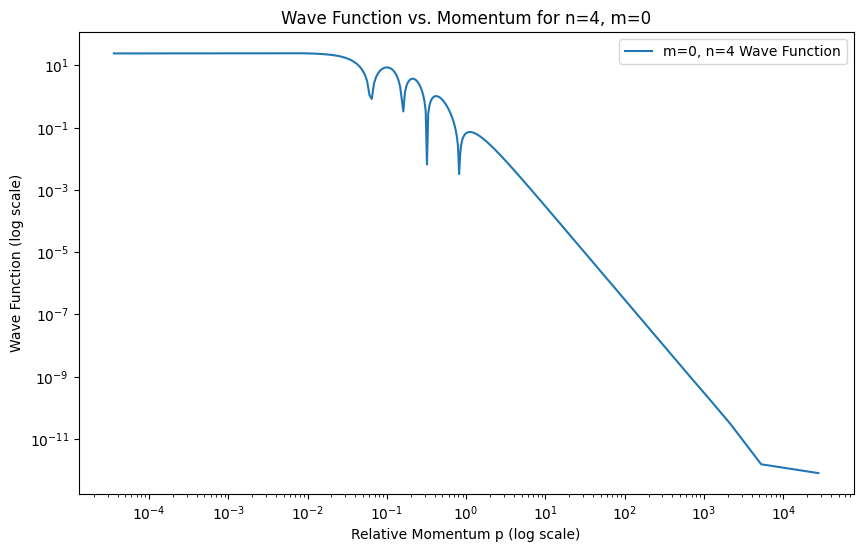

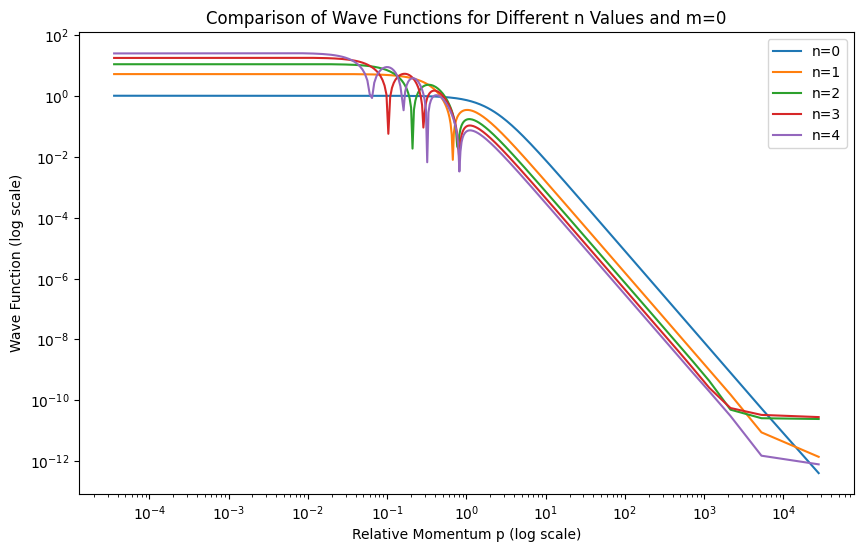

In [20]:
# -----------------------
# Main Program
# -----------------------
def main():
    p, dp = hyperbolic(Np)
    phi, dphi = linear(Nphi, 0, 2.0 * pi)
    xp = np.cos(phi)
    WF_matrix = []

    # Loop over values of n from m up to 4
    for n in range(m, 5):  # m to 4, inclusive
        E_exact = -ONE / (n + 0.5)**2  # Calculate the exact energy for each n
        BE2_1 = E_exact * 0.95  # Lower bound for energy estimate
        BE2_2 = E_exact * 1.05  # Upper bound for energy estimate

        V_2B_2d = compute_V_2B(Np, Nphi, m, p, xp, phi, dphi)
        BE2, WF = LS_2D(Np, p, dp, V_2B_2d, BE2_1, BE2_2)
        rel_error = np.abs((BE2 - E_exact) / E_exact) * 100
        WF_matrix.append(WF)

        print(f'For n = {n}:')
        print(f'Computed BE2: {BE2}')
        print(f'Exact Energy: {E_exact}')
        print(f'Relative Error: {rel_error}%\n')

        plt.figure(figsize=(10, 6))  # Initialize the plot for all wave functions
        plt.figure(figsize=(10, 6))
        plt.loglog(p, WF, label=f'm={m}, n={n} Wave Function')
        plt.xlabel('Relative Momentum p (log scale)')
        plt.ylabel('Wave Function (log scale)')
        plt.title(f'Wave Function vs. Momentum for n={n}, m={m}')
        # plt.grid(True, which="both", ls="--")
        plt.legend()
        plt.show()

        plt.figure(figsize=(10, 6))
    for i, WF in enumerate(WF_matrix):
        plt.loglog(p, WF, label=f'n={i}')
    plt.xlabel('Relative Momentum p (log scale)')
    plt.ylabel('Wave Function (log scale)')
    plt.title(f'Comparison of Wave Functions for Different n Values and m={m}')
    # plt.grid(True, which="both", ls="--")
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()